In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 598ms/step - loss: 0.1344
Average validation loss: 0.7318771481513977
4/4 [==============================] - 6s 612ms/step - loss: 0.1344 - val_loss: 0.7319
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 593ms/step - loss: 0.1019 - val_loss: 0.7319
Average validation loss: 0.7268645763397217
4/4 [==============================] - 8s 606ms/step - loss: 0.1019 - val_loss: 0.7294
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 593ms/step - loss: 0.0777 - val_loss: 0.7294
Average validation loss: 0.6816228628158569
4/4 [==============================] - 11s 607ms/step - loss: 0.0777 - val_loss: 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 702ms/step - loss: 0.0029
Average validation loss: 0.001984928152523935
8/8 [==============================] - 6s 718ms/step - loss: 0.0029 - val_loss: 0.0020
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 712ms/step - loss: 0.0030 - val_loss: 0.0020
Average validation loss: 7.0628880166623276e-06
8/8 [==============================] - 12s 726ms/step - loss: 0.0030 - val_loss: 9.9600e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 18s 744ms/step - loss: 0.0030 - val_loss: 9.9600e-04
Average validation loss: 2.4385293500017724e-06
8/8 [==============================] - 18s 758ms/step - los

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 712ms/step - loss: 0.0037
Average validation loss: 0.028503964344660442
12/12 [==============================] - 9s 724ms/step - loss: 0.0037 - val_loss: 0.0285
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 712ms/step - loss: 0.0036 - val_loss: 0.0285
Average validation loss: 0.030427071925563116
12/12 [==============================] - 17s 723ms/step - loss: 0.0036 - val_loss: 0.0295
Epoch 3/10
12/12 [==============================] - 26s 740ms/step - loss: 0.0036 - val_loss: 0.0295
Average validation loss: 0.0454640700093781
12/12 [==============================] - 26s 751ms/step - loss: 0.0036 - val_loss: 0.0348
Epoch 4/10
12/12 [==============================] - 35s 703ms/step - loss: 0.0035 - val_loss: 0.0348
Average validation loss: 0.06617788186607261
12

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 709ms/step - loss: 0.0033
Average validation loss: 0.029261597326694755
16/16 [==============================] - 12s 721ms/step - loss: 0.0033 - val_loss: 0.0293
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 709ms/step - loss: 0.0031 - val_loss: 0.0293
Average validation loss: 0.032152263803084224
16/16 [==============================] - 23s 722ms/step - loss: 0.0031 - val_loss: 0.0307
Epoch 3/10
16/16 [==============================] - 35s 722ms/step - loss: 0.0031 - val_loss: 0.0307
Average validation loss: 0.029419860600683023
16/16 [==============================] - 35s 734ms/step - loss: 0.0031 - val_loss: 0.0303
Epoch 4/10
16/16 [==============================] - 46s 728ms/step - loss: 0.0031 - val_loss: 0.0303
Average validation loss: 0.0625438112765550

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 714ms/step - loss: 0.0021
Average validation loss: 0.04873934418646968
20/20 [==============================] - 14s 726ms/step - loss: 0.0021 - val_loss: 0.0487
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 715ms/step - loss: 0.0021 - val_loss: 0.0487
Average validation loss: 0.03204130850499496
20/20 [==============================] - 29s 726ms/step - loss: 0.0021 - val_loss: 0.0404
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 43s 708ms/step - loss: 0.0020 - val_loss: 0.0404
Average validation loss: 0.03446494104664453
20/20 [==============================] - 43s 720ms/step - loss

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 712ms/step - loss: 0.0021
Average validation loss: 0.04534214300413927
24/24 [==============================] - 17s 723ms/step - loss: 0.0021 - val_loss: 0.0453
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 719ms/step - loss: 0.0029 - val_loss: 0.0453
Average validation loss: 0.056332310661673546
24/24 [==============================] - 35s 729ms/step - loss: 0.0029 - val_loss: 0.0508
Epoch 3/10
24/24 [==============================] - 52s 710ms/step - loss: 0.0026 - val_loss: 0.0508
Average validation loss: 0.044367254401246704
24/24 [==============================] - 52s 721ms/step - loss: 0.0026 - val_loss: 0.0487
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 28s 710ms/step - loss: 0.0026
Average validation loss: 0.0502204455435276
40/40 [==============================] - 29s 721ms/step - loss: 0.0026 - val_loss: 0.0502
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 57s 713ms/step - loss: 0.0025 - val_loss: 0.0502
Average validation loss: 0.08768473193049431
40/40 [==============================] - 58s 724ms/step - loss: 0.0025 - val_loss: 0.0690
Epoch 3/10
40/40 [==============================] - 86s 713ms/step - loss: 0.0023 - val_loss: 0.0690
Average validation loss: 0.039929520711302756
40/40 [==============================] - 87s 724ms/step - loss: 0.0023 - val_loss: 0.0593
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\s

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 712ms/step - loss: 0.0020
Average validation loss: 0.023186107379236393
48/48 [==============================] - 35s 723ms/step - loss: 0.0020 - val_loss: 0.0232
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 69s 715ms/step - loss: 0.0018 - val_loss: 0.0232
Average validation loss: 0.02329632291609111
48/48 [==============================] - 70s 726ms/step - loss: 0.0018 - val_loss: 0.0232
Epoch 3/10
48/48 [==============================] - 104s 708ms/step - loss: 0.0016 - val_loss: 0.0232
Average validation loss: 0.01539662015390301
48/48 [==============================] - 104s 721ms/step - loss: 0.0016 - val_loss: 0.0206
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 716ms/step - loss: 0.0020
Average validation loss: 0.017615132192524134
56/56 [==============================] - 41s 727ms/step - loss: 0.0020 - val_loss: 0.0176
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 81s 712ms/step - loss: 0.0017 - val_loss: 0.0176
Average validation loss: 0.02076247592944875
56/56 [==============================] - 81s 724ms/step - loss: 0.0017 - val_loss: 0.0192
Epoch 3/10
56/56 [==============================] - 122s 722ms/step - loss: 0.0016 - val_loss: 0.0192
Average validation loss: 0.02532038824938354
56/56 [==============================] - 123s 733ms/step - loss: 0.0016 - val_loss: 0.0212
Epoch 4/10
56/56 [==============================] - 162s 708ms/step - loss: 0.0015 - val_loss: 0.0212
Average validation loss: 0.019820781989242

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 45s 709ms/step - loss: 0.0015
Average validation loss: 0.01804588467399526
64/64 [==============================] - 46s 721ms/step - loss: 0.0015 - val_loss: 0.0180
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 92s 709ms/step - loss: 0.0012 - val_loss: 0.0180
Average validation loss: 0.01558010524760789
64/64 [==============================] - 92s 721ms/step - loss: 0.0012 - val_loss: 0.0168
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 138s 715ms/step - loss: 0.0010 - val_loss: 0.0168
Average validation loss: 0.01199875160727748
64/64 [==============================] - 139s 727ms/step - lo

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 711ms/step - loss: 0.0014
Average validation loss: 0.015399967760054601
72/72 [==============================] - 52s 722ms/step - loss: 0.0014 - val_loss: 0.0154
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 104s 717ms/step - loss: 0.0012 - val_loss: 0.0154
Average validation loss: 0.01975309365015063
72/72 [==============================] - 105s 728ms/step - loss: 0.0012 - val_loss: 0.0176
Epoch 3/10
72/72 [==============================] - 156s 710ms/step - loss: 0.0010 - val_loss: 0.0176
Average validation loss: 0.013986536353412602
72/72 [==============================] - 157s 722ms/step - loss: 0.0010 - val_loss: 0.0164
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_05

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 57s 718ms/step - loss: 0.0014
Average validation loss: 0.0163223828189075
80/80 [==============================] - 58s 729ms/step - loss: 0.0014 - val_loss: 0.0163
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 116s 720ms/step - loss: 0.0011 - val_loss: 0.0163
Average validation loss: 0.0178984556812793
80/80 [==============================] - 117s 732ms/step - loss: 0.0011 - val_loss: 0.0171
Epoch 3/10
80/80 [==============================] - 174s 713ms/step - loss: 9.8809e-04 - val_loss: 0.0171
Average validation loss: 0.010746515216305852
80/80 [==============================] - 175s 724ms/step - loss: 9.8809e-04 - val_loss: 0.0150
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segfor

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 720ms/step - loss: 0.0019
Average validation loss: 0.022816561819733277
96/96 [==============================] - 70s 732ms/step - loss: 0.0019 - val_loss: 0.0228
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 139s 711ms/step - loss: 0.0015 - val_loss: 0.0228
Average validation loss: 0.02548835896110783
96/96 [==============================] - 140s 723ms/step - loss: 0.0015 - val_loss: 0.0242
Epoch 3/10
96/96 [==============================] - 208s 712ms/step - loss: 0.0013 - val_loss: 0.0242
Average validation loss: 0.022797094386381406
96/96 [==============================] - 209s 724ms/step - loss: 0.0013 - val_loss: 0.0237
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 85s 713ms/step - loss: 0.0014
Average validation loss: 0.016131681649828047
120/120 [==============================] - 87s 724ms/step - loss: 0.0014 - val_loss: 0.0161
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 172s 711ms/step - loss: 0.0011 - val_loss: 0.0161
Average validation loss: 0.009959969300689408
120/120 [==============================] - 174s 722ms/step - loss: 0.0011 - val_loss: 0.0130
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 259s 714ms/step - loss: 9.7086e-04 - val_loss: 0.0130
Average validation loss: 0.008623375582343822
120/120 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 113s 782ms/step - loss: 0.0011
Average validation loss: 0.012796135468912931
144/144 [==============================] - 114s 794ms/step - loss: 0.0011 - val_loss: 0.0128
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 228s 786ms/step - loss: 9.0407e-04 - val_loss: 0.0128
Average validation loss: 0.010636479767400588
144/144 [==============================] - 230s 798ms/step - loss: 9.0407e-04 - val_loss: 0.0117
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 335s 729ms/step - loss: 7.9189e-04 - val_loss: 0.0117
Average validation loss: 0.011940491193905068
144/144 [=====================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 717ms/step - loss: 8.7664e-04
Average validation loss: 0.01376943119103089
160/160 [==============================] - 117s 728ms/step - loss: 8.7664e-04 - val_loss: 0.0138
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 231s 715ms/step - loss: 7.2907e-04 - val_loss: 0.0138
Average validation loss: 0.01647825966902019
160/160 [==============================] - 233s 727ms/step - loss: 7.2907e-04 - val_loss: 0.0151
Epoch 3/10
160/160 [==============================] - 347s 713ms/step - loss: 6.3906e-04 - val_loss: 0.0151
Average validation loss: 0.007452407083019352
160/160 [==============================] - 349s 725ms/step - loss: 6.3906e-04 - val_loss: 0.0126
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 142s 712ms/step - loss: 0.0016
Average validation loss: 0.01625841717068397
200/200 [==============================] - 145s 723ms/step - loss: 0.0016 - val_loss: 0.0163
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 287s 713ms/step - loss: 0.0013 - val_loss: 0.0163
Average validation loss: 0.012164714986283798
200/200 [==============================] - 290s 724ms/step - loss: 0.0013 - val_loss: 0.0142
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 432s 711ms/step - loss: 0.0011 - val_loss: 0.0142
Average validation loss: 0.011408467996443506
200/200 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:54 - loss: 4.2207e-04

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 171s 712ms/step - loss: 9.7920e-04
Average validation loss: 0.013218886236427353
240/240 [==============================] - 174s 724ms/step - loss: 9.7920e-04 - val_loss: 0.0132
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 345s 714ms/step - loss: 8.0618e-04 - val_loss: 0.0132
Average validation loss: 0.016013865247562837
240/240 [==============================] - 348s 725ms/step - loss: 8.0618e-04 - val_loss: 0.0146
Epoch 3/10
240/240 [==============================] - 519s 712ms/step - loss: 7.1403e-04 - val_loss: 0.0146
Average validation loss: 0.01177852618682588
240/240 [==============================] - 521s 723ms/step - loss: 7.1403e-04 - val_loss: 0.0137
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.13264242999007425, 0.051813831212338075, 0.06057911927650588, 0.05754550086111088, 0.03982916711436997, 0.03632186762554076, 0.02666506042168567, 0.017751090162318045, 0.018343389278144655, 0.015461669438690394, 0.011692193065325682, 0.0096163320145954, 0.01230702734172155, 0.009904358946817106, 0.010024721180907015, 0.007299592777228783, 0.008504091433918028, 0.01150524599300086]
std_val_losses =  [0.22386442810595922, 0.043399583095570994, 0.038268952105553096, 0.03739154120656434, 0.024994806950658144, 0.025898247291232187, 0.01468768527683723, 0.007610660015296609, 0.008140387271448123, 0.011209335932964817, 0.006469539921232974, 0.003282720333625801, 0.005880786624316206, 0.005374562126546487, 0.0042626356280615575, 0.003423248613063041, 0.002823736354857639, 0.014623094658641521]


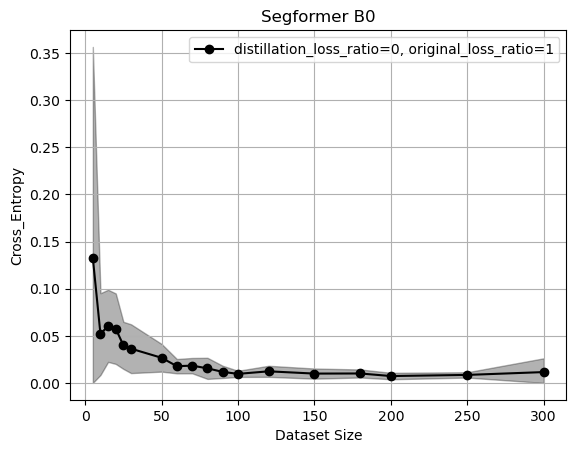

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()